# Materials Project Element Distribution by Arity


In [ ]:
# dash needed for interactive plots
!pip install pymatviz dash jupyter-dash

In [ ]:
import dash
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
from pymatgen.ext.matproj import MPRester

from pymatviz import count_elements, ptable_heatmap, ptable_heatmap_plotly


__author__ = "Janosh Riebesell"
__date__ = "2022-07-21"


pio.templates.default = "plotly_white"
# Interactive plotly figures don't show up on GitHub.
# https://github.com/plotly/plotly.py/issues/931
# change renderer from "svg" to "notebook" to get hover tooltips back
# (but blank plots on GitHub!)
pio.renderers.default = "png"

In [ ]:
PMG_MAPI_KEY = "your Materials Project API key"

with MPRester(PMG_MAPI_KEY) as mpr:
    mp_data = mpr.query(
        criteria={"nelements": {"$lte": 4}},
        properties=["material_id", "pretty_formula", "nelements"],
    )

df_mp = pd.DataFrame(mp_data).set_index("material_id")

In [ ]:
# uncomment line to cache large MP data
# %store df_mp

# uncomment line to load cached MP data from disk
%store -r df_mp

In [ ]:
elem_counts_by_arity = {
    label: count_elements(df_mp.query(f"nelements == {idx}").pretty_formula)
    for idx, label in enumerate(["unary", "binary", "ternary", "quaternary"], 1)
}

compound_counts_by_arity = {
    key: (df_mp.nelements == idx).sum()
    for idx, key in enumerate(elem_counts_by_arity, 1)
}

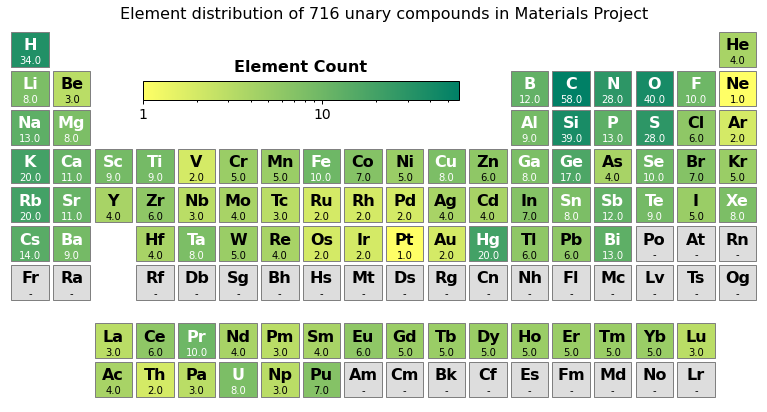

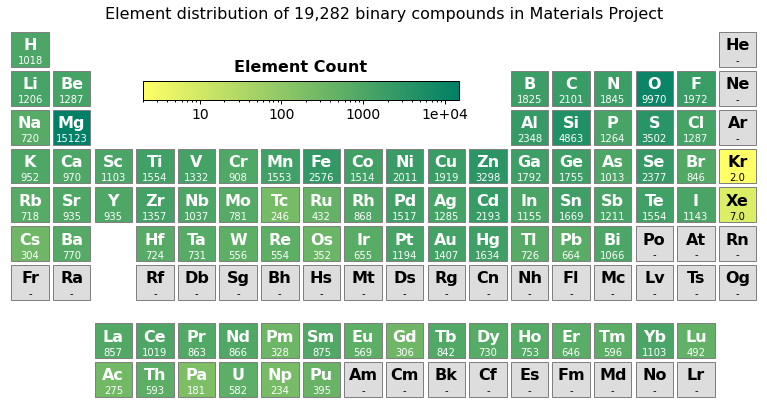

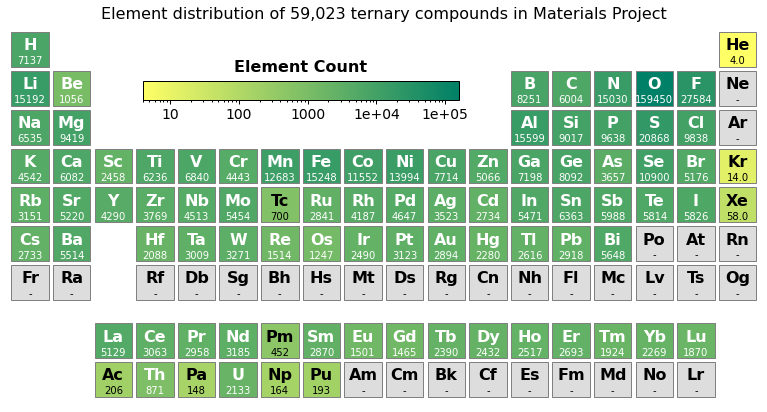

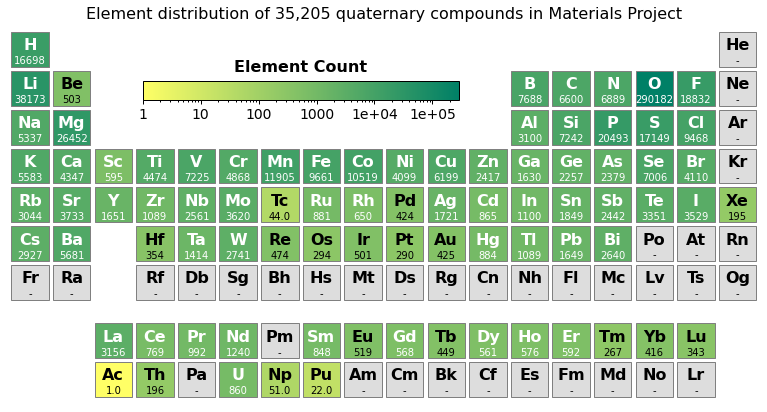

In [ ]:
for arity_label, elem_counts in elem_counts_by_arity.items():
    ax = ptable_heatmap(elem_counts, log=True)
    n_compounds = compound_counts_by_arity[arity_label]
    ax.set_title(
        f"Element distribution of {n_compounds:,} {arity_label} compounds in "
        "Materials Project",
        fontsize=16,
    )

In [ ]:
arity_figs = {}
for arity_label, elem_counts in elem_counts_by_arity.items():
    fig = ptable_heatmap_plotly(
        elem_counts,
        hover_props=["atomic_number", "type"],
        heat_mode="percent",
    )
    n_compounds = compound_counts_by_arity[arity_label]

    title = (
        f"<b>Element distribution of {n_compounds:,} <i>{arity_label}</i> compounds<br>"
        "in Materials Project</b>"
    )
    fig.update_layout(title=dict(text=title, x=0.45, y=0.93))
    arity_figs[arity_label] = fig
    # fig.show()  # uncomment to show plotly figures

In [ ]:
app = JupyterDash(prevent_initial_callbacks=True)

graph = dash.dcc.Graph(figure=fig, id="ptable-heatmap", responsive=True)
dropdown = dash.dcc.Dropdown(
    id="arity-dropdown",
    options=[
        dict(label=arity_label, value=arity_label)
        for arity_label in elem_counts_by_arity
    ],
    style=dict(width="15em", position="absolute", top="15%", left="30%"),
    value="unary",
    placeholder="Select arity",
)
main_layout = dash.html.Div([graph, dropdown], style=dict(fontFamily="sans-serif"))
app.layout = main_layout


@app.callback(Output(graph.id, "figure"), Input(dropdown.id, "value"))
def update_figure(dropdown_value: str) -> go.Figure:
    """Update figure based on dropdown value."""
    return arity_figs[dropdown_value]


app.run(debug=True, mode="inline")